In [5]:
import os
import shutil
import numpy as np
import glob  
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50                                                                      
from tensorflow.keras.applications.resnet50 import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline      

In [6]:
import cv2
def enhance_image(image):
   
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = list(cv2.split(lab))
    lab_planes[0] = clahe.apply(lab_planes[0])
    
    # Apply median denoising
    lab_planes[0] = cv2.medianBlur(lab_planes[0], 3)
    
    # Apply Gaussian denoising
    lab_planes[0] = cv2.GaussianBlur(lab_planes[0], (3, 3), 0)
    
    # Segment leaf area using color thresholding
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([25, 52, 72])
    upper_green = np.array([102, 255, 255])
    leaf_mask = cv2.inRange(hsv, lower_green, upper_green)
    leaf_area = cv2.bitwise_and(lab_planes[0], leaf_mask)
    
    # Segment disease-affected area using thresholding
    hsv_red_lower = np.array([0, 50, 50])
    hsv_red_upper = np.array([10, 255, 255])
    hsv_red2_lower = np.array([170, 50, 50])
    hsv_red2_upper = np.array([180, 255, 255])
    red_mask1 = cv2.inRange(hsv, hsv_red_lower, hsv_red_upper)
    red_mask2 = cv2.inRange(hsv, hsv_red2_lower, hsv_red2_upper)
    disease_mask = cv2.bitwise_or(red_mask1, red_mask2)
    disease_area = cv2.bitwise_and(lab_planes[0], disease_mask)
    
    # Add disease-affected area to the segmented leaf area
    segmented_image = cv2.bitwise_or(leaf_area, disease_area)
    
    lab_planes[0] = segmented_image
    
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)



# Where all dataset is there
data_dir = 'C:/code/paddy-disease/training/PlantVillage'

# Training data dir
training_dir = 'C:/code/paddy-disease/training/Train'

# Test data dir
testing_dir = 'C:/code/paddy-disease/training/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 
def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
        os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
        os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))
        #print(os.path.join(all_data_dir, subdir)) 
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

        for lists in train_list : 
            img = cv2.imread(lists)
            img_enhanced = enhance_image(img)
            cv2.imwrite(training_data_dir + '/' + category_name + '/' + os.path.basename(lists), img_enhanced)
            num_training_files += 1
  
        for lists in test_list : 
            img = cv2.imread(lists)
            img_enhanced = enhance_image(img)
            cv2.imwrite(testing_data_dir + '/' + category_name + '/' + os.path.basename(lists), img_enhanced)
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")


In [7]:
split_dataset_into_test_and_train_sets()

bacterial_leaf_blight has 438 images
brown_spot has 466 images
healthy has 464 images
leaf_blast has 454 images
leaf_scald has 448 images
narrow_brown_spot has 440 images
Processed 2167 training files.
Processed 543 testing files.


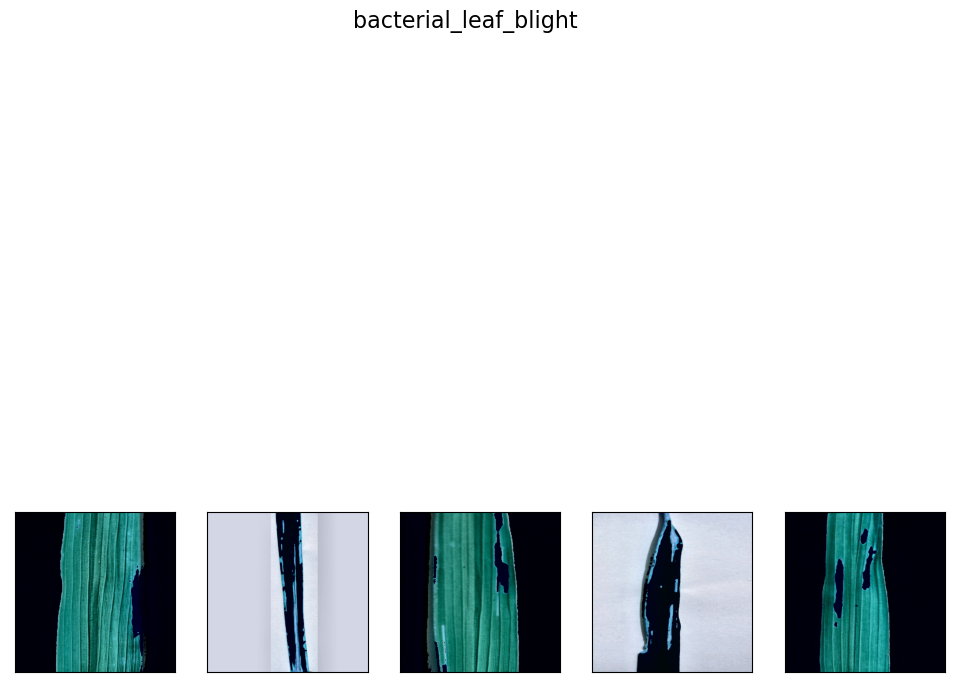

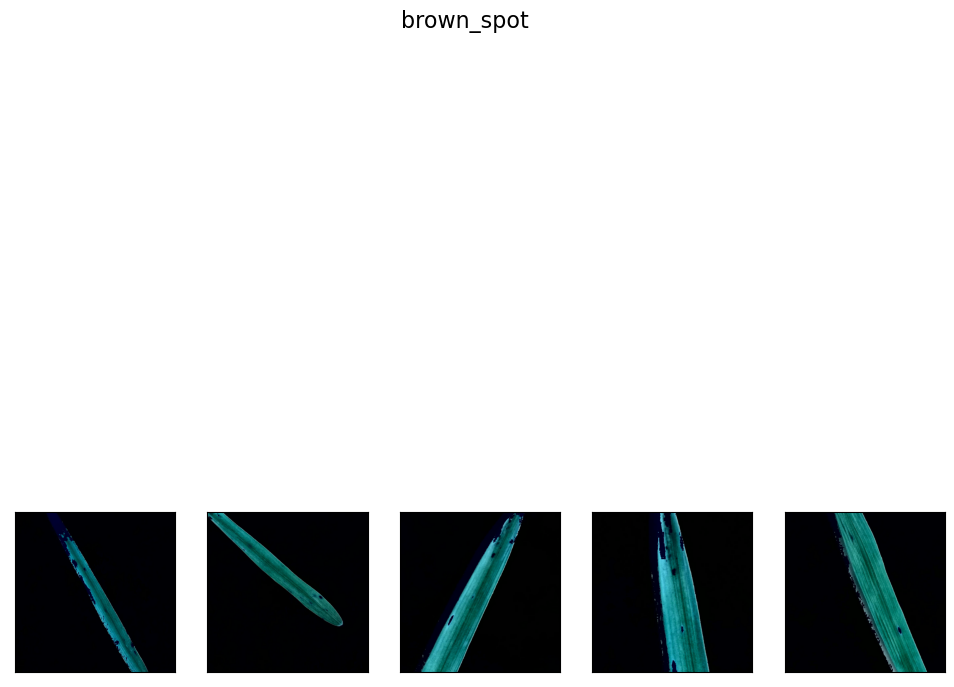

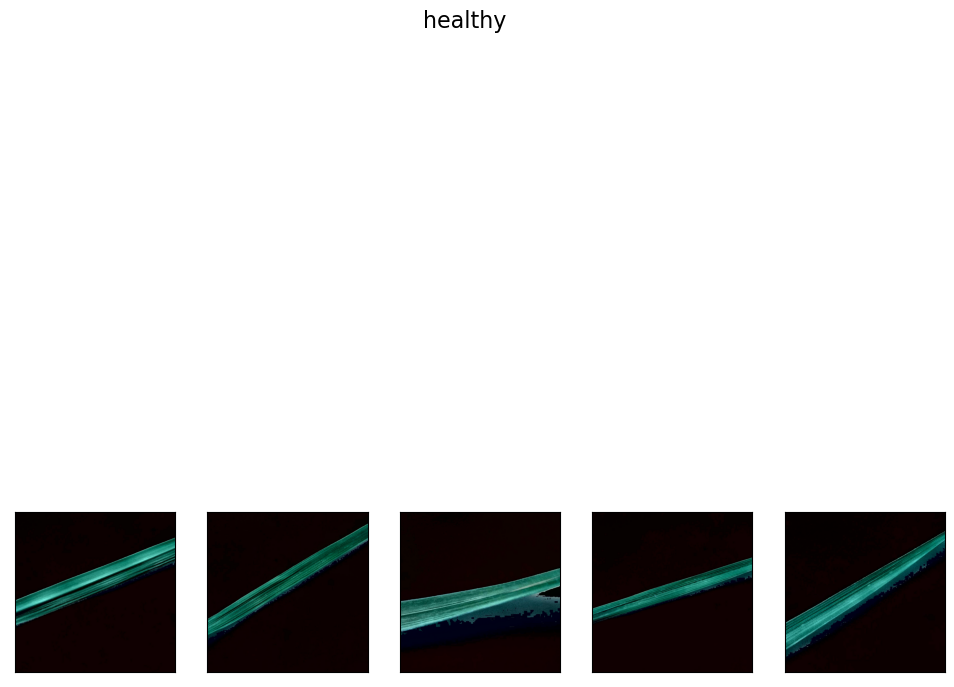

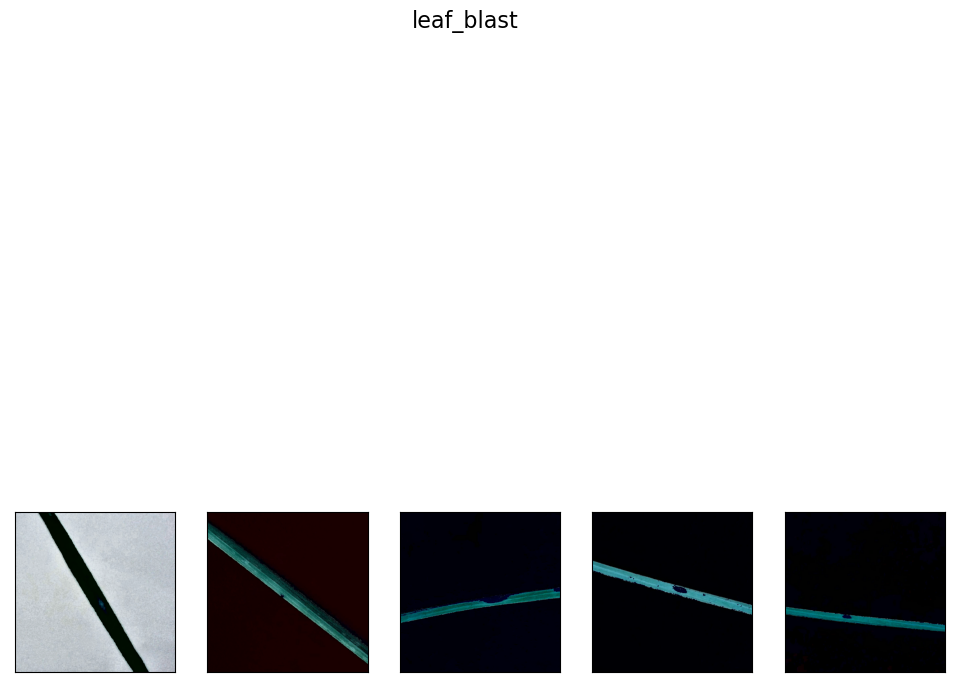

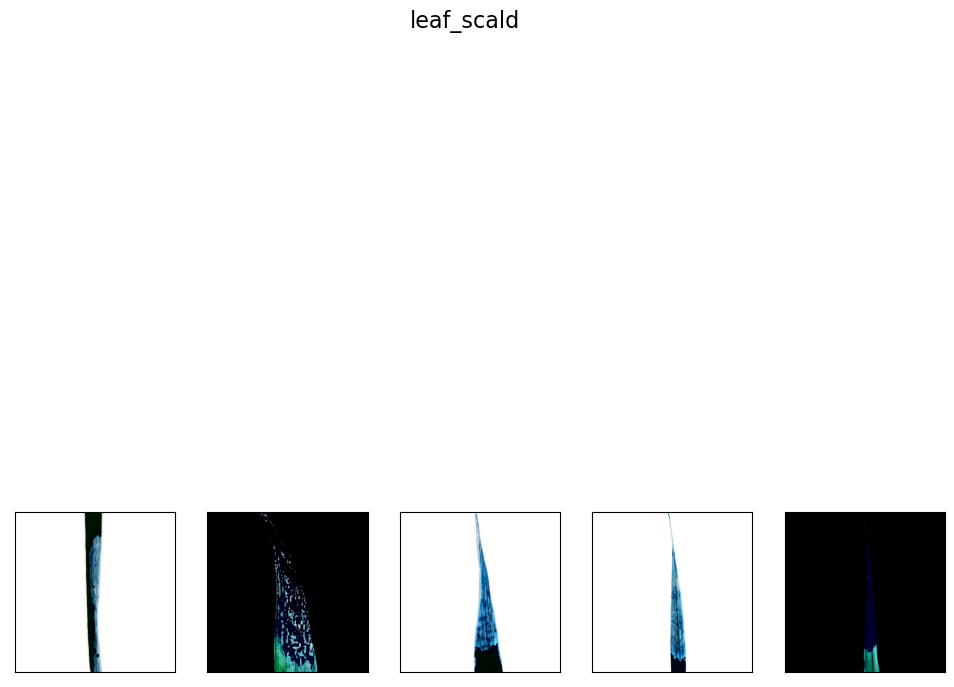

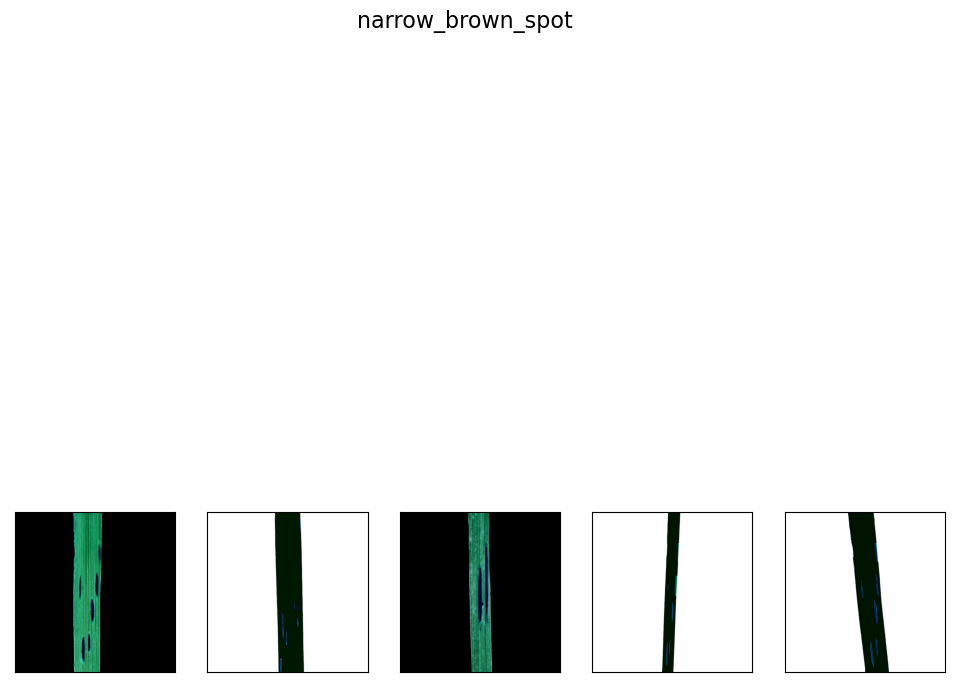

In [8]:
import matplotlib.pyplot as plt

# Plot sample images of each class
for subdir, dirs, files in os.walk(training_dir):
    category_name = os.path.basename(subdir)
    if category_name == os.path.basename(training_dir):
        continue
    
    # Plot some images from each class
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
    fig.suptitle(category_name, fontsize=16)
    for i in range(5):
        img = cv2.imread(os.path.join(subdir, files[i]))
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()


In [9]:
num_classes = 6

def get_model():
    base_model = ResNet50(weights='imagenet', include_top=False)
 
    for layer in base_model.layers:
        layer.trainable = False
        
    base_model_ouput = base_model.output
    
    # Adding our own layer 
    x = GlobalAveragePooling2D()(base_model_ouput)
    # Adding fully connected layer
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [10]:
# Get the model
model = get_model()
# Compile it

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Summary of model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [11]:
# Number of classes in dataset
num_classes = 6
image_size=224
batch_size=32
# Get the model
model = get_model()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall() ])

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=20)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_gen.flow_from_directory(training_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

valid_generator = valid_data_gen.flow_from_directory(testing_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

from sklearn.utils.class_weight import compute_class_weight

# Set up data generators with class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
# Set up callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.2 ** epoch)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Found 2604 images belonging to 6 classes.
Found 980 images belonging to 6 classes.
Epoch 1/30
82/82 [==============================] - 415s 5s/step - loss: 0.7838 - accuracy: 0.7227 - precision: 0.7833 - recall: 0.6636 - val_loss: 0.4899 - val_accuracy: 0.8051 - val_precision: 0.8223 - val_recall: 0.7745 - lr: 0.0010
Epoch 2/30
82/82 [==============================] - 413s 5s/step - loss: 0.3267 - accuracy: 0.8863 - precision: 0.9078 - recall: 0.8625 - val_loss: 0.3306 - val_accuracy: 0.8898 - val_precision: 0.9036 - val_recall: 0.8704 - lr: 2.0000e-04
Epoch 3/30
82/82 [==============================] - 415s 5s/step - loss: 0.2775 - accuracy: 0.9075 - precision: 0.9245 - recall: 0.8840 - val_loss: 0.3242 - val_accuracy: 0.8867 - val_precision: 0.9072 - val_recall: 0.8673 - lr: 4.0000e-05
Epoch 4/30
82/82 [==============================] - 410s 5s/step - loss: 0.2659 - accuracy: 0.9109 - precision: 0.9257 - recall: 0.8902 - val_loss: 0.3210 - val_accuracy: 0.8878 - val_precision: 0.9083

In [13]:
# Unfreeze some layers in the pre-trained model
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model with fine-tuning
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Epoch 1/50
82/82 [==============================] - 748s 9s/step - loss: 0.4753 - accuracy: 0.8387 - precision_2: 0.8641 - recall_2: 0.8034 - auc_1: 0.9749 - val_loss: 9.9377 - val_accuracy: 0.5918 - val_precision_2: 0.5965 - val_recall_2: 0.5898 - val_auc_1: 0.7930 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 737s 9s/step - loss: 0.1895 - accuracy: 0.9332 - precision_2: 0.9415 - recall_2: 0.9267 - auc_1: 0.9951 - val_loss: 0.2338 - val_accuracy: 0.9286 - val_precision_2: 0.9331 - val_recall_2: 0.9245 - val_auc_1: 0.9914 - lr: 2.0000e-04
Epoch 3/50
82/82 [==============================] - 812s 10s/step - loss: 0.1350 - accuracy: 0.9535 - precision_2: 0.9568 - recall_2: 0.9516 - auc_1: 0.9978 - val_loss: 0.1597 - val_accuracy: 0.9459 - val_precision_2: 0.9468 - val_recall_2: 0.9449 - val_auc_1: 0.9967 - lr: 4.0000e-05
Epoch 4/50
82/82 [==============================] - 779s 10s/step - loss: 0.1184 - accuracy: 0.9585 - precision_2: 0.9599 - recall_2: 0.9562 - auc_1: 0

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the test data
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_gen.flow_from_directory(testing_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical')

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels = test_generator.classes

# Print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_true_labels, y_pred_labels))
print('Confusion Matrix:')
print(confusion_matrix(y_true_labels, y_pred_labels))


Found 980 images belonging to 6 classes.
31/31 [==============================] - 95s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       163
           1       0.92      0.85      0.89       165
           2       0.97      0.99      0.98       171
           3       0.90      0.89      0.90       160
           4       0.99      0.99      0.99       163
           5       0.93      0.98      0.96       158

    accuracy                           0.95       980
   macro avg       0.95      0.95      0.95       980
weighted avg       0.95      0.95      0.95       980

Confusion Matrix:
[[162   0   0   0   0   1]
 [  1 141   3  14   0   6]
 [  0   1 170   0   0   0]
 [  0  11   3 143   0   3]
 [  1   0   0   0 161   1]
 [  0   0   0   2   1 155]]


In [15]:
history

In [16]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 82}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_auc_1', 'lr'])

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

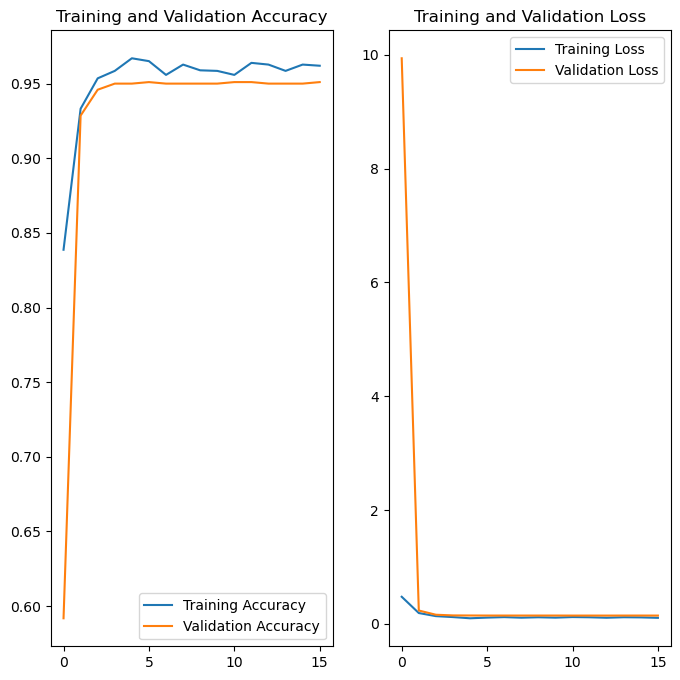

In [19]:
import matplotlib.pyplot as plt
epochs=16
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
class_names = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 144ms/step


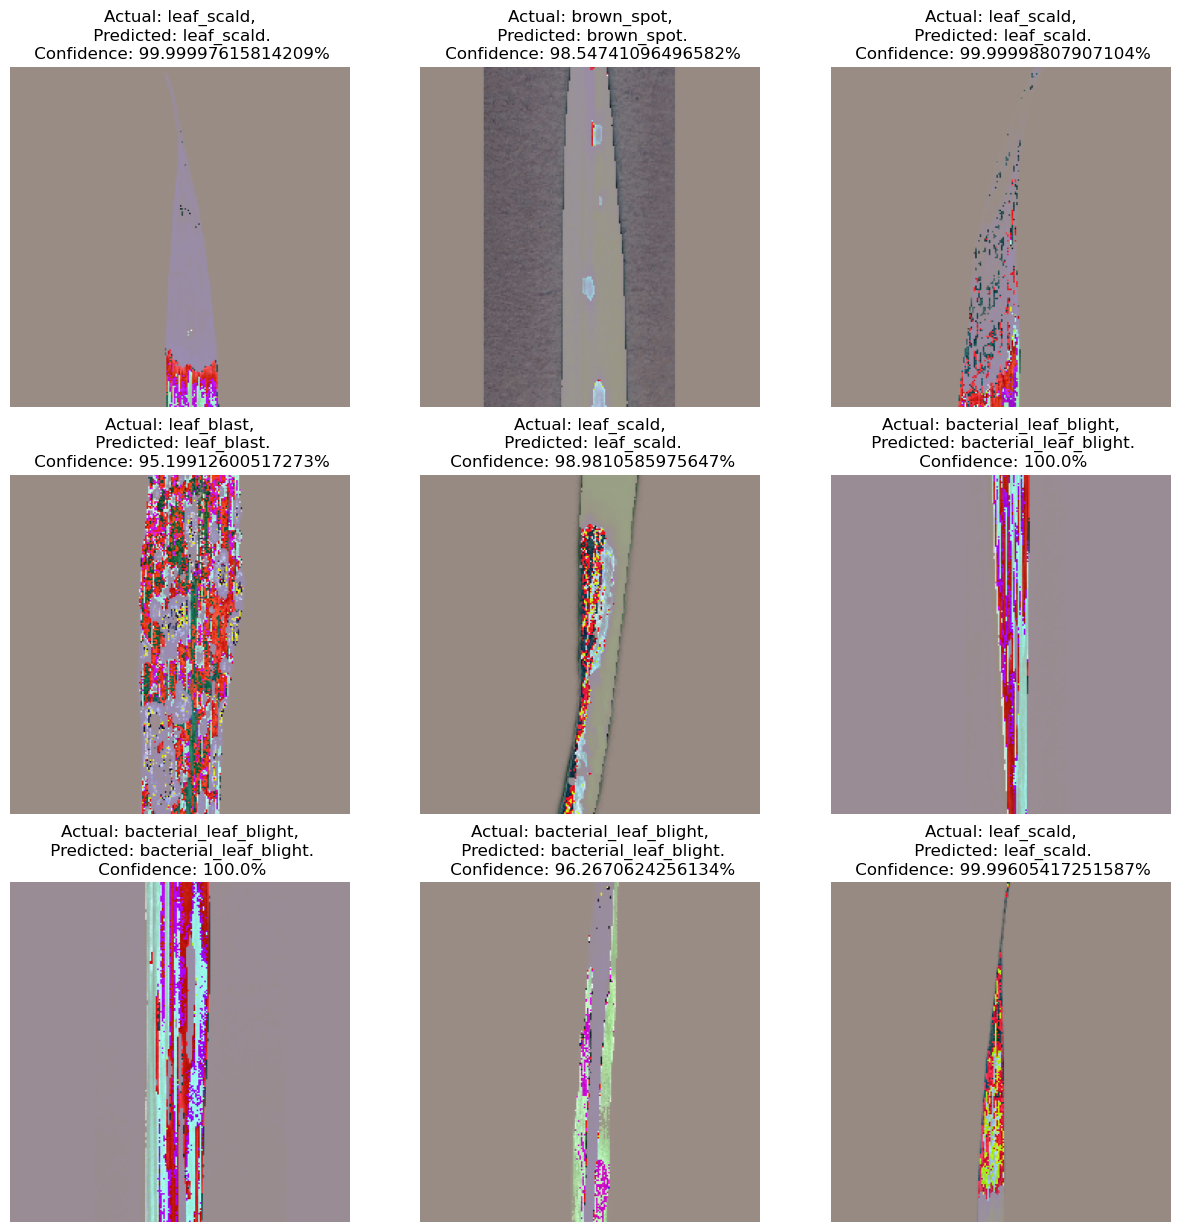

In [26]:
plt.figure(figsize=(15, 15))
images, labels = next(valid_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))

    predicted_class_probs = model.predict(np.expand_dims(images[i], axis=0))[0]
    predicted_class = class_names[np.argmax(predicted_class_probs)]
    confidence = predicted_class_probs[np.argmax(predicted_class_probs)] * 100
    actual_class = class_names[np.argmax(labels[i])]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


In [27]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [28]:
model.save("../paddy.h5")

In [29]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('../paddy.h5')

# Convert the model to TFLite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('paddy_optimized.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpq7tygrfs\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpq7tygrfs\assets
